<a href="https://colab.research.google.com/github/koleshjr/Predicting-Air-Quality-in-Uganda/blob/main/catboost_airquality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIR QUALITY

## Install necesssary Libraries

In [ ]:
# !pip install catboost
# !pip install optuna
# # !pip install geopy
# !pip install -U layer

## Setup Layer

In [ ]:
import layer
from layer.decorators import dataset,model, pip_requirements
layer.login()


Please open the following link in your web browser. Once logged in, copy the code and paste it here.
https://app.layer.ai/oauth/authorize?response_type=code&code_challenge=-3xBipvEKi3rm_V639BTYMl-lrUgcYfUP5_ZRYjv6SY&code_challenge_method=S256&client_id=0STDdcnpK48P8A429EAAn93WNuLmViLR&redirect_uri=https://app.layer.ai/oauth/code&scope=offline_access&audience=https://app.layer.ai
Code: OHD9WtkGSyepEoXtj_wZYB8xzqs720n5ACCZq-PZxw0Uh
Successfully logged into https://app.layer.ai


In [ ]:
layer.init("sample-air-quality-Grouped-Time-Series")

Your Layer project is here: https://app.layer.ai/koleshjr/sample-air-quality-Grouped-Time-Series

## Import necessary Libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as catt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm as tqdm_notebook

from sklearn.model_selection import train_test_split, KFold,GroupKFold,TimeSeriesSplit, StratifiedKFold

from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = 2200
pd.options.display.max_columns = 2200

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import optuna

from geopy.geocoders import Nominatim
from geopy.point import Point
import requests
from io import StringIO 

## fetch datasets from layer

In [ ]:
sub= layer.get_dataset("zindi/air-quality/datasets/sample_submission").to_pandas()
test = layer.get_dataset("zindi/air-quality/datasets/test").to_pandas()
train = layer.get_dataset("zindi/air-quality/datasets/train").to_pandas()

Output()

Output()

Output()

In [ ]:
train.head(2)

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
0,ID_JBYXJEUZ8X,2020-03-18,ANQ16PZJ,0.35346,32.56032,0.84684,22.03854,-0.00014,1.04263,-0.00014,0.29136,76.59491,10.25336,-93.09162,19.18137,-0.00001,0.03374,2457.11182,1353.66467,829636.00000,70.37299,10.31243,-93.00801,19.19493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00012,1.54410,0.00009,0.29136,19.18137,-93.09162,10.25336,76.59491,-1.64226,829649.46231,76.61416,10.02307,-93.10610,19.20809,0.11678,2.08862,0.24753,228.15512,0.41042,76.61416,10.02307,-93.10610,19.20809,0.43680,61535.80469,4181.79297,69589.45312,3181.79346,7.79985,0.27811,76.61855,9.97029,-93.11007,19.21419,63.85333
1,ID_PEJJNLBUPR,2019-10-13,AB6051M4,0.39074,32.58226,0.87449,21.54583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21781,829826.62500,-97.72382,58.45699,-103.69569,36.37274,0.11728,3.03799,0.35978,226.43236,0.46068,-97.72382,58.45699,-103.69569,36.37274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.50708


### Sort the Data because satelite date is timeseries like in nature

In [ ]:
train = train.sort_values(by=['date']).reset_index(drop=True)
test = test.sort_values(by=['date']).reset_index(drop=True)
train.date.max(),train.date.min(), test.date.max(),test.date.min()

('2020-08-20', '2019-03-14', '2020-12-31', '2020-08-20')

In [ ]:
train[['date', 'pm2_5']]

,date,pm2_5
0,2019-03-14,31.41500
1,2019-03-15,28.94000
2,2019-03-16,34.34927
3,2019-03-17,43.13188
4,2019-03-18,30.58446
...,...,...
9918,2020-08-20,84.79917
9919,2020-08-20,45.81200
9920,2020-08-20,61.87583
9921,2020-08-20,53.92308


## Visualize Missing values and deal with them

In [ ]:
#check for missing values
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
column_more_than_half_miss = missing_value_train[missing_value_train['percent_missing'] > 50]['column_name'].to_list()

train = train.drop(column_more_than_half_miss, axis=1)
test  = test.drop(column_more_than_half_miss, axis=1)

In [ ]:
cat_columns = [col for col in train.select_dtypes('object').columns]
num_columns = [col for col in train.select_dtypes(['int', 'float']).columns if col not in ['pm2_5']]

### Concat both datasets for easy manipulation

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
nan_cols = [c for c in data.columns if c not in ["ID","pm2_5", "device"]]
nan_cols = data[nan_cols].columns[data[nan_cols].isnull().any()].tolist()

for col in nan_cols:
    
    while data[col].isnull().sum()>0:
     
        data[col].fillna(data[["device", col]].groupby(["device"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True) 

data.isnull().sum()[data.isnull().sum()>0]

pm2_5    4254
dtype: int64

### Check if temp and hum are of the required ranges

In [ ]:
temp_hum = ['temp_mean','humidity']
data[temp_hum].describe()

,temp_mean,humidity
count,14177.00000,14177.00000
mean,21.49991,0.79275
std,3.87594,0.15020
min,0.00000,0.00000
25%,21.16548,0.77513
50%,22.18949,0.82266
75%,23.13194,0.86669
max,29.73500,1.00000


temperature and humidity are of the required range

## Visualizing our Target and View the stats

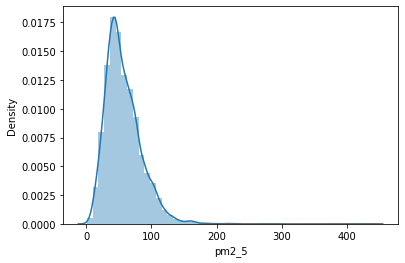

In [ ]:
sns.distplot((data.pm2_5))

In [ ]:
data.pm2_5.describe()

count   9923.00000
mean      57.10731
std       27.48295
min        1.16040
25%       38.02829
50%       51.93024
75%       72.03312
max      440.92000
Name: pm2_5, dtype: float64

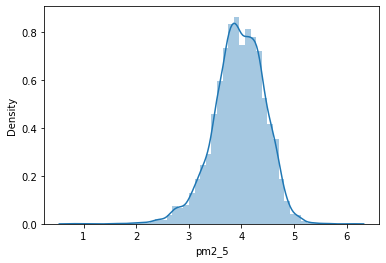

In [ ]:
sns.distplot(np.log1p(data.pm2_5))

### Deal with potential outliers

In [ ]:
data['CarbonMonoxide_H2O_column_number_density'].loc[data['CarbonMonoxide_H2O_column_number_density'] >5377.06104]  = 5377.06104
data['Cloud_cloud_optical_depth'].loc[data['Cloud_cloud_optical_depth'] >97.46741]  = 97.46741

data['pm2_5'] = np.where(data['pm2_5']  >= data['pm2_5'].quantile(0.97), data['pm2_5'].quantile(0.97),data['pm2_5'])

In [ ]:
#outliers_cols =[ col for col in data.columns if col not in ['ID','date','device','site_latitude','site_longitude','lat_lon', 'CarbonMonoxide_H2O_column_number_density', 'Cloud_cloud_optical_depth',
#                                                      'UvAerosolIndex_sensor_zenith_angle','UvAerosolIndex_sensor_azimuth_angle','SulphurDioxide_sensor_zenith_angle','pm2_5',  
#    'SulphurDioxide_SO2_column_number_density_amf','SulphurDioxide_SO2_column_number_density_15km','Ozone_O3_slant_column_number_density','Ozone_sensor_zenith_angle','Ozone_solar_zenith_angle','Cloud_sensor_azimuth_angle','UvAerosolIndex_absorbing_aerosol_index']]
#for k in outliers_cols:
#    data[k] = np.where(data[k]  >= data[k].quantile(0.99), data[k].quantile(0.99),data[k])

### Categorical Features visualization

In [ ]:
categorical_behaving_cols = ['device',
'site_latitude',
'site_longitude',]

In [ ]:
# check unique values in dataset
data[categorical_behaving_cols].apply(lambda x: len(x.unique()))

device            36
site_latitude     48
site_longitude    36
dtype: int64

aq_30       598
aq_41       586
aq_45       500
aq_43       491
aq_46       486
aq_49       485
AKSLS0FP    462
A0WN66FH    462
AY2J2Q7Z    462
AB6051M4    462
AJCK5L86    462
APYZC5J7    462
ANQ16PZJ    462
AR2RHV97    462
APZ80RTM    462
AW66FF7V    462
A95X5F9T    462
aq_29       447
aq_54       417
aq_36       404
aq_61       400
aq_52       399
aq_59       395
aq_70       372
aq_35       348
aq_74       336
aq_47       332
aq_56       324
aq_31       314
aq_79       307
aq_60       295
aq_57       294
aq_76       245
aq_64       237
aq_91        80
aq_98         3
Name: device, dtype: int64


Text(0.5, 0, 'device')

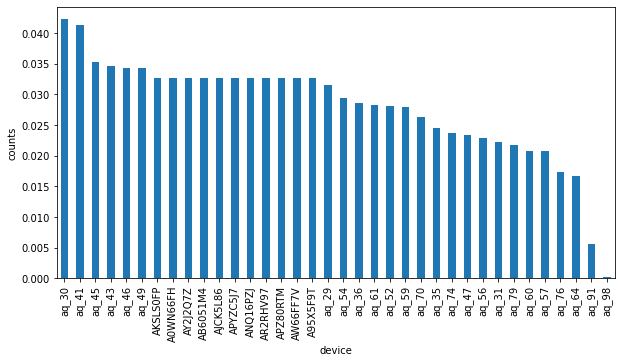

In [ ]:
print(data['device'].value_counts())
plt.figure(figsize=(10,5))
data['device'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('device')

0.05960     598
-1.24499    586
0.34400     500
0.28904     491
0.29875     486
0.28368     485
0.26501     462
0.28575     462
0.30758     462
0.39074     462
0.34390     462
0.34373     462
0.30667     462
0.31545     462
0.31997     462
0.30750     447
0.35346     446
0.37956     444
0.35640     417
0.35483     404
0.28659     372
0.21820     371
0.37308     344
0.38158     339
0.30749     336
0.31010     324
0.36075     323
0.34701     314
0.36021     300
0.30778     295
0.35470     289
0.35799     245
0.39148     228
0.35170     200
0.35170     132
0.33261      83
0.38158      52
0.37308      49
0.21820      28
0.36075      25
0.35346      16
0.37956      12
0.39148       9
0.37308       7
0.36021       7
0.37956       6
0.35470       5
0.38158       4
Name: site_latitude, dtype: int64


Text(0.5, 0, 'site_latitude')

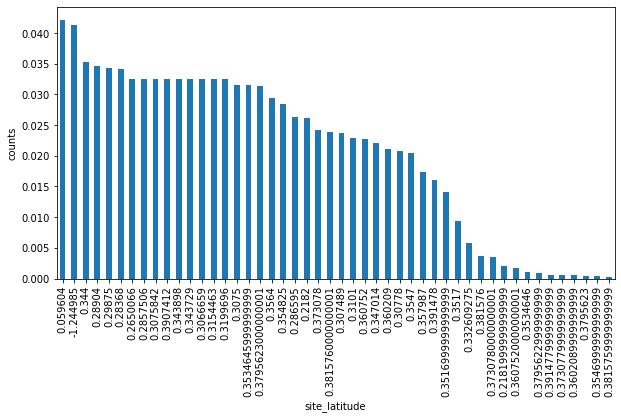

In [ ]:
print(data['site_latitude'].value_counts())
plt.figure(figsize=(10,5))
data['site_latitude'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('site_latitude')

32.46032    598
32.55300    500
32.58958    491
32.61500    486
32.60048    485
32.62560    462
32.57833    462
32.56708    462
32.58226    462
32.58723    462
32.59555    462
32.56032    462
32.55131    462
32.60855    462
32.58671    462
32.55371    462
32.62060    447
32.57300    417
32.67781    404
32.62823    400
32.61760    399
32.64711    395
32.50611    372
32.75257    348
32.61176    336
32.59100    332
29.98924    327
32.51600    324
32.64936    314
32.61076    307
32.65145    295
32.50260    294
29.98924    259
32.58410    245
32.62583    237
32.61005     83
Name: site_longitude, dtype: int64


Text(0.5, 0, 'site_longitude')

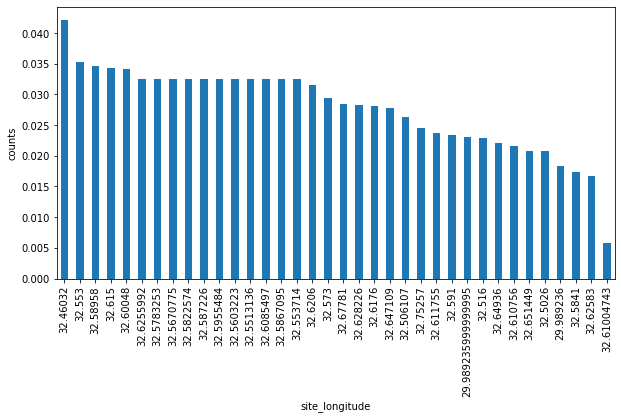

In [ ]:
print(data['site_longitude'].value_counts())
plt.figure(figsize=(10,5))
data['site_longitude'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('site_longitude')

### Label encoding the cat features 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_columns = [col for col in data.select_dtypes('object').columns if col not in ['ID','date']]

for col in le_columns:
   data[col] = le.fit_transform(data[col])

### Convert datetime variables to datetime objects

In [ ]:
data["date"] = pd.to_datetime(data.date)

## FEATURE ENGINEERING

In [ ]:
data['lat_lon'] = data['site_latitude'].astype(str) + '_' + data['site_longitude'].astype(str)

### Lag cols
* This was supposed to be done very carefully by grouping with the device or the place
* for me the previous day values were very meaningful


In [ ]:
lag_cols =[ col for col in data.columns if col not in ['ID','date','device','site_latitude','site_longitude','lat_lon',
                                                      'UvAerosolIndex_sensor_zenith_angle','UvAerosolIndex_sensor_azimuth_angle','SulphurDioxide_sensor_zenith_angle','pm2_5',  
    'SulphurDioxide_SO2_column_number_density_amf','SulphurDioxide_SO2_column_number_density_15km','Ozone_O3_slant_column_number_density','Ozone_sensor_zenith_angle','Ozone_solar_zenith_angle','Cloud_sensor_azimuth_angle','UvAerosolIndex_absorbing_aerosol_index']]

for col in lag_cols:

    for i in range(1, 2):#
        data[f'prev_{col}_{i}'] = data.groupby('device')[col].shift(i)
           
    data[f'gb_feature_place{col}_{i}']  = data.groupby(['device'])[col].transform('min')
    data[f'gb_feature_place2{col}_{i}'] = data.groupby(['CarbonMonoxide_CO_column_number_density'])[col].transform('max') # -> This line

## Date Features 

In [ ]:
# Extract day, month year and hour from the Datetime column
# day
data['Datetime_day'] = data.date.dt.day

# month
data['Datetime_month'] = data.date.dt.month


data['weekday'] =data.date.dt.weekday

data['month_day'] = data['Datetime_month'].astype(str) + '_' + data['Datetime_day'].astype(str)
data['month_wkday'] = data['Datetime_month'].astype(str) + '_' + data['weekday'].astype(str)



In [ ]:
le_columns = ['month_day','month_wkday','lat_lon','date']

for col in le_columns:
   data[col] = le.fit_transform(data[col])

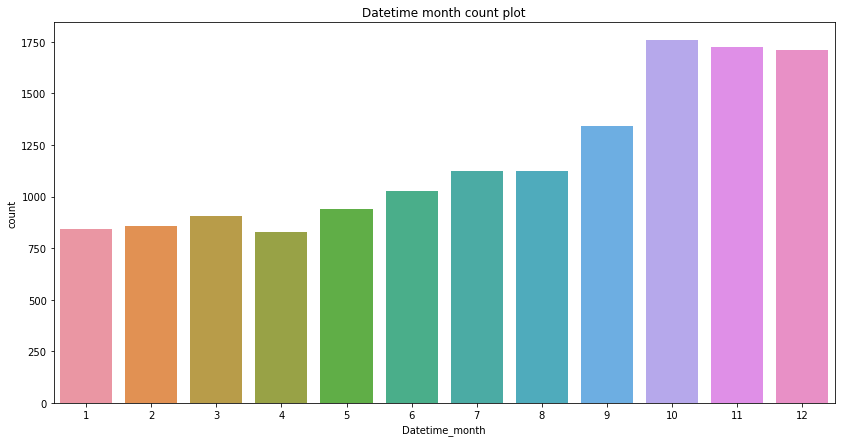

In [ ]:
# Datetime month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'Datetime_month', data = data)
plt.title('Datetime month count plot')
plt.show()

### Count encoding

In [ ]:
cat_cols = ['device','lat_lon','site_latitude','site_longitude','weekday','month_day','month_wkday','humidity','temp_mean']

## Count of unique features
for i in cat_cols:
    data['count_'+i] = data[i].map(data[i].value_counts())
# cat_cols

## Separate the Train and test data

In [ ]:
 train_df = data[:ntrain]
test_df = data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((9923, 176), (4254, 176))

## Modelling

In [ ]:
# Select main columns to be used in training
main_cols = train_df.columns.difference([
    'temp_mean_sum','humidity_max','UvAerosolIndex_sensor_zenith_angle','UvAerosolIndex_sensor_azimuth_angle','SulphurDioxide_sensor_zenith_angle','ID',
    'SulphurDioxide_SO2_column_number_density_amf','SulphurDioxide_SO2_column_number_density_15km', 
    'UvAerosolIndex_absorbing_aerosol_index','weekday','count_month_wkday',
    'pm2_5','Datetime_hour','temp_mean','Ozone_O3_slant_column_number_density','Ozone_sensor_zenith_angle','Ozone_solar_zenith_angle','Cloud_sensor_azimuth_angle','device','site_longitude','site_latitude','humidity'])


((2481, 160), (7442, 160), (2481,), (7442,), (4254, 160))

In [ ]:
X = train_df[main_cols]
y = train_df['pm2_5']
X_test = test_df[main_cols] 
X.shape,X_test.shape

((9923, 160), (4254, 160))

## Cross Validation
* I tried all kfold was not reliable. Tried stratifiedkfold was not reliable. Tried Timeseriessplit and was not giving me good results. Lastly I Tried GroupTimeSeriesSplit which was a bit reliable but not entirely

In [ ]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

## CATBOOST MODELLING

In [ ]:
fold_pred=[]
oof_pred = []

params = {'max_depth': 5, 'learning_rate': 0.054311625828468046, 'l2_leaf_reg': 0.023393133390917083,'iterations':10000}





fold= GroupTimeSeriesSplit(n_splits=10)
i=1
for train_index, test_index in fold.split(X,y, groups = X['Datetime_month']):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = (y.iloc[train_index]), y.iloc[test_index]

    model = catt.CatBoostRegressor(**params,eval_metric='MAE',random_state=42)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=500, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_absolute_error(y_test,(preds))))  #Reverse transformation
    oof_pred.append(mean_absolute_error(y_test,(preds)))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append((p2))
    

print(np.mean(oof_pred))

err:  9.388156294888173
err:  13.177427743918168
err:  12.830469670957
err:  12.883971734075365
err:  15.430324228869381
err:  18.303130532419885
err:  12.026279649030238
err:  18.350998351990857
err:  19.65433349762437
err:  14.938577050408721
14.698366875418216


## Submission

In [ ]:
sub_df = test_df[['ID']].copy()
sub_df['pm2_5'] = np.mean(fold_pred, axis = 0)
sub_df.head()

,ID,pm2_5
9923,ID_OC21YTIKX2,66.55684
9924,ID_ZS2RAN8HZT,61.80432
9925,ID_X5RLD131U1,58.96787
9926,ID_3O2ZUT59OO,62.66277
9927,ID_WGF1986WB4,46.86732


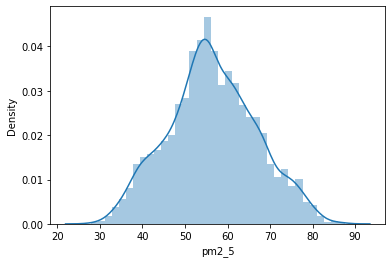

In [ ]:
sns.distplot(sub_df['pm2_5'])

In [ ]:
sub_df.to_csv('catboost_ts_1.csv', index=False)


## Conclusion
* filling nans the right way was key
* This model scores 12.80 on the lb with only 160 features which is pretty awesome(seventh on the lb but too bad I did not choose this)
* Thank you @ Tauil and @ Suresh for teaming up with me